In [1]:
import pandas as pd

Наши новости

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [4]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [7]:
pip install gensim

  Created wheel for smart-open: filename=smart_open-4.0.1-py3-none-any.whl size=108253 sha256=151c68bd8840fa7e82badc1ce64a226d021c92357a496b4cb047189ff6ddd08f
  Stored in directory: c:\users\c753~1\appdata\local\pip\cache\wheels\34\3d\14\f19c01a19c9201cdb6a76b049904d5226912569be919ad1eae
Successfully built smart-open
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.15
    Uninstalling Cython-0.29.15:
      Successfully uninstalled Cython-0.29.15
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install razdel

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install pymorphy2

  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13709 sha256=435fed1eb3b6e844f727df906fa39bfd45473514256792c3dd5666e6ae4f33b0
  Stored in directory: c:\users\c753~1\appdata\local\pip\cache\wheels\72\b0\3f\1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt
Note: you may need to restart the kernel to use updated packages.


In [12]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [20]:
#предобработка текстов
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to C:\Users\Элла
[nltk_data]     Дмитриева\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [21]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [22]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [23]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [24]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 2min 1s


In [25]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 18min


А теперь в 3 строчки обучим нашу модель

In [26]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [27]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [28]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 4min 22s


In [29]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [30]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.0685828),
 (7, 0.043074876),
 (8, 0.38953653),
 (11, 0.21956058),
 (18, 0.26144344)]

In [31]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: украина это банк украинский nn который писать
topic_1: тыс область регион северный район nn год
topic_2: конкурс супруг опрос доход орудие плата компенсировать
topic_3: год который российский россия это также санкция
topic_4: который это nn суд женщина год выяснить
topic_5: налог кость метро художественный вена воспаление присудить
topic_6: газ пациент исследование край учреждение сократиться nn
topic_7: мышь польша польский донбасс немец франция повышаться
topic_8: товар фестиваль египет сайт теория гость подробность
topic_9: млн млрд составить доход банк доллар компания
topic_10: золото рт альянс коллекция рекорд стремительно кг
topic_11: год это страна который система рост земля
topic_12: пенсия восток определение звонок этаж облегчить эндрю
topic_13: тело взрыв земля жертва достигать мальчик штат
topic_14: это который мочь исследование россия всё год
topic_15: мозг лаборатория фрагмент бизнесмен билет звезда миллиардер
topic_16: год человек который это обнаружить свой ребё

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [32]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [33]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.0,0.045951,0.0,0.0,0.000000,0.000000,0.047637,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.898379
1,4896,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.211063,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000
2,4897,0.069985,0.0,0.0,0.000000,0.0,0.0,0.000000,0.043186,0.389609,...,0.0,0.0,0.0,0.260577,0.0,0.0,0.0,0.00000,0.000000,0.000000
3,4898,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.124406,...,0.0,0.0,0.0,0.487667,0.0,0.0,0.0,0.02895,0.229631,0.000000
4,4899,0.000000,0.0,0.0,0.000000,0.0,0.0,0.588111,0.048527,0.120105,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.057004


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [34]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [35]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [36]:
doc_dict[293622]

array([0.        , 0.05064644, 0.        , 0.        , 0.19681561,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01653241, 0.        , 0.12440695,
       0.        , 0.08690751, 0.        , 0.        , 0.        ,
       0.21311454, 0.        , 0.        , 0.        , 0.30064654])

In [57]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, variant):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if variant == 'mean':
        user_vector = np.mean(user_vector, 0)
    elif variant == 'median':
        user_vector = np.median(user_vector, 0)
    elif variant == 'max':
        user_vector = np.max(user_vector, 0)
    return user_vector

In [58]:
get_user_embedding(user_articles_list, 'mean')

array([0.07247121, 0.0107049 , 0.        , 0.10257027, 0.09596709,
       0.        , 0.        , 0.        , 0.        , 0.01228995,
       0.        , 0.05941364, 0.        , 0.        , 0.10166042,
       0.        , 0.12258418, 0.        , 0.04849667, 0.        ,
       0.1488836 , 0.        , 0.01219149, 0.03604302, 0.16467877])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [59]:
#users['articles'].iloc[33]

In [60]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

Для get_user_embedding с 'mean':

In [80]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x,'mean'), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.202204,0.101843,0.000000,0.067990,0.114709,0.0128,0.007855,0.0,0.052437,...,0.0,0.054526,0.0,0.000000,0.0,0.104524,0.0,0.002483,0.018600,0.052275
1,u108690,0.162717,0.009737,0.011001,0.171370,0.110779,0.0000,0.000000,0.0,0.000000,...,0.0,0.103111,0.0,0.071346,0.0,0.049630,0.0,0.022629,0.001912,0.088247
2,u108339,0.092049,0.079086,0.000000,0.121886,0.125109,0.0000,0.016450,0.0,0.000000,...,0.0,0.197583,0.0,0.018629,0.0,0.102237,0.0,0.009182,0.023883,0.038809


Для get_user_embedding с 'median':

In [77]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x,'median'), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.204521,0.034124,0.0,0.035266,0.134857,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.063848,0.0,0.000000,0.0,0.000000
1,u108690,0.169765,0.000000,0.0,0.155232,0.102241,0.0,0.000000,0.0,0.0,...,0.0,0.097889,0.0,0.078110,0.0,0.034100,0.0,0.015044,0.0,0.068835
2,u108339,0.109312,0.049917,0.0,0.079129,0.115821,0.0,0.005755,0.0,0.0,...,0.0,0.198355,0.0,0.019394,0.0,0.032483,0.0,0.000000,0.0,0.044572


Для get_user_embedding с 'max':

In [78]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x,'max'), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.445044,0.444173,0.000000,0.186968,0.221728,0.044224,0.047132,0.0,0.250043,...,0.0,0.240248,0.0,0.000000,0.0,0.286332,0.0,0.014897,0.096934,0.300647
1,u108690,0.269046,0.058423,0.034557,0.346613,0.279398,0.000000,0.000000,0.0,0.000000,...,0.0,0.193417,0.0,0.112539,0.0,0.159549,0.0,0.061853,0.011474,0.183492
2,u108339,0.201153,0.288408,0.000000,0.322428,0.287350,0.000000,0.063988,0.0,0.000000,...,0.0,0.413459,0.0,0.045898,0.0,0.359667,0.0,0.031738,0.129315,0.072849


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [79]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


X для user_embeddings_mean

In [82]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.202204,0.101843,0.000000,0.067990,0.114709,0.0128,0.007855,0.0,0.052437,...,0.054526,0.0,0.000000,0.0,0.104524,0.0,0.002483,0.018600,0.052275,0
1,u108690,0.162717,0.009737,0.011001,0.171370,0.110779,0.0000,0.000000,0.0,0.000000,...,0.103111,0.0,0.071346,0.0,0.049630,0.0,0.022629,0.001912,0.088247,1
2,u108339,0.092049,0.079086,0.000000,0.121886,0.125109,0.0000,0.016450,0.0,0.000000,...,0.197583,0.0,0.018629,0.0,0.102237,0.0,0.009182,0.023883,0.038809,1


X для user_embeddings_median

In [83]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.204521,0.034124,0.0,0.035266,0.134857,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.063848,0.0,0.000000,0.0,0.000000,0
1,u108690,0.169765,0.000000,0.0,0.155232,0.102241,0.0,0.000000,0.0,0.0,...,0.097889,0.0,0.078110,0.0,0.034100,0.0,0.015044,0.0,0.068835,1
2,u108339,0.109312,0.049917,0.0,0.079129,0.115821,0.0,0.005755,0.0,0.0,...,0.198355,0.0,0.019394,0.0,0.032483,0.0,0.000000,0.0,0.044572,1


In [84]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.445044,0.444173,0.000000,0.186968,0.221728,0.044224,0.047132,0.0,0.250043,...,0.240248,0.0,0.000000,0.0,0.286332,0.0,0.014897,0.096934,0.300647,0
1,u108690,0.269046,0.058423,0.034557,0.346613,0.279398,0.000000,0.000000,0.0,0.000000,...,0.193417,0.0,0.112539,0.0,0.159549,0.0,0.061853,0.011474,0.183492,1
2,u108339,0.201153,0.288408,0.000000,0.322428,0.287350,0.000000,0.063988,0.0,0.000000,...,0.413459,0.0,0.045898,0.0,0.359667,0.0,0.031738,0.129315,0.072849,1


In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [88]:
#разделим данные на train/test для mean
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_mean['churn'], random_state=0)

In [89]:
#разделим данные на train/test для median
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [90]:
#разделим данные на train/test для max
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

Обучение модели для X_train_mean 

In [91]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train_mean, y_train_mean)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
#наши прогнозы для тестовой выборки
preds_mean = logreg.predict_proba(X_test_mean)[:, 1]
preds_mean[:10]

array([0.04384991, 0.1567477 , 0.61244328, 0.3130947 , 0.00793675,
       0.02353271, 0.11175701, 0.03304909, 0.17123601, 0.10506176])

Обучение модели для X_train_median

In [95]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train_median, y_train_median)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
#наши прогнозы для тестовой выборки
preds_median = logreg.predict_proba(X_test_median)[:, 1]
preds_median[:10]

array([0.010413  , 0.00765185, 0.69375282, 0.38842504, 0.00600881,
       0.02275403, 0.01883274, 0.00838983, 0.14806315, 0.0522686 ])

Обучение модели для X_train_max

In [97]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train_max, y_train_max)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
#наши прогнозы для тестовой выборки
preds_max = logreg.predict_proba(X_test_max)[:, 1]
preds_max[:10]

array([7.20466610e-02, 1.30074776e-02, 8.64503746e-01, 1.10330593e-01,
       6.25588800e-04, 1.10225654e-02, 1.67854438e-01, 1.27314086e-04,
       3.70376603e-02, 8.36247613e-02])

In [68]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

Для preds_mean

In [132]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test_mean, preds_mean)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix = np.argmax(fscore_mean)
print('Best Threshold_mean=%f, F-Score_mean=%.3f, Precision_mean=%.3f, Recall_mean=%.3f' % (thresholds_mean[ix], 
                                                                        fscore_mean[ix],
                                                                        precision_mean[ix],
                                                                        recall_mean[ix]))
thresholds_mean = round(thresholds_mean[ix], 3)
fscore_mean = round(fscore_mean[ix], 3)
precision_mean = round(precision_mean[ix], 3)
recall_mean = round(recall_mean[ix], 3)

Best Threshold_mean=0.325826, F-Score_mean=0.718, Precision_mean=0.709, Recall_mean=0.727


Для preds_median

In [129]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore_median)
print('Best Threshold_median=%f, F-Score_median=%.3f, Precision_median=%.3f, Recall_median=%.3f' % (thresholds_median[ix], 
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

thresholds_median = round(thresholds_median[ix],3)
fscore_median = round(fscore_median[ix],3)
precision_median = round(precision_median[ix],3)
recall_median = round(recall_median[ix],3)

Best Threshold_median=0.356780, F-Score_median=0.775, Precision_median=0.791, Recall_median=0.759


Для preds_max

In [131]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test_max, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold_max=%f, F-Score_max=%.3f, Precision_max=%.3f, Recall_max=%.3f' % (thresholds_max[ix], 
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

thresholds_max = round(thresholds_max[ix], 3)
fscore_max = round(fscore_max[ix], 3)
precision_max = round(precision_max[ix], 3)
recall_max = round(recall_max[ix], 3)

Best Threshold_max=0.400435, F-Score_max=0.807, Precision_max=0.822, Recall_max=0.792


In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Для preds_mean

Confusion matrix, without normalization
[[1714   41]
 [ 102  143]]


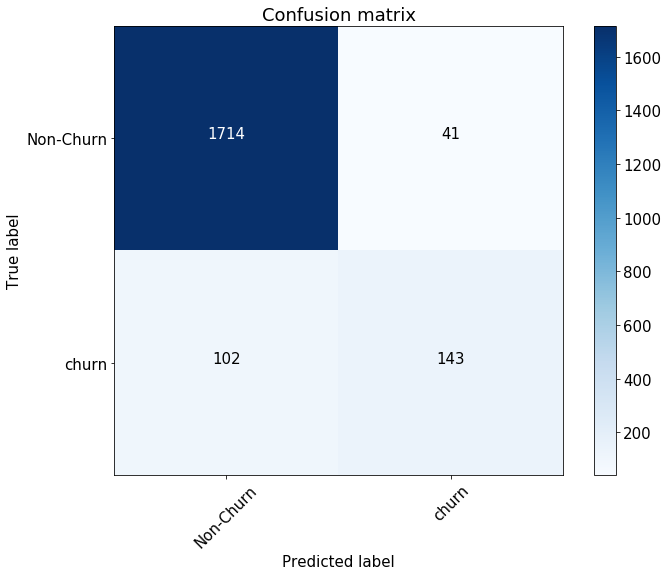

In [103]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_mean, preds_mean>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для preds_median

Confusion matrix, without normalization
[[1715   40]
 [  76  169]]


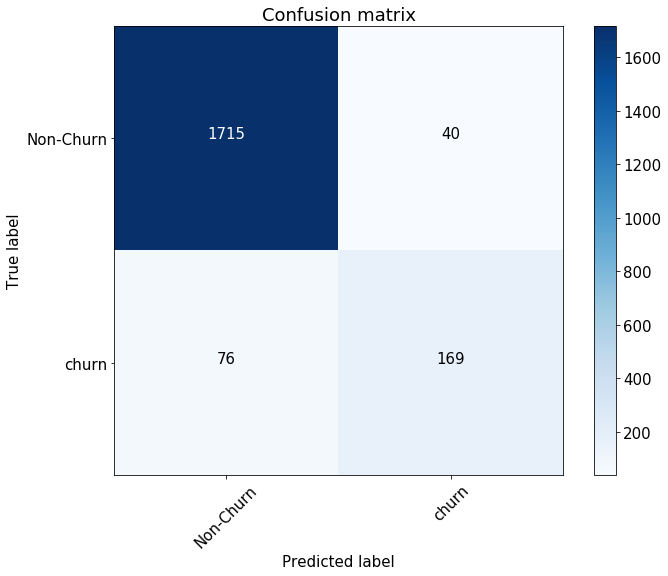

In [104]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_median, preds_median>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для preds_max

Confusion matrix, without normalization
[[1713   42]
 [  52  193]]


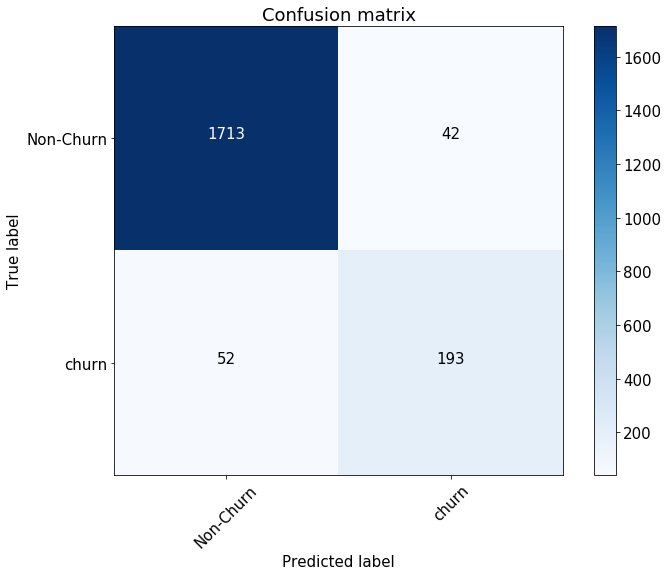

In [105]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_max, preds_max>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Для preds_mean

In [106]:
roc_auc_score(y_test_mean, preds_mean)

0.9610163381591952

Для preds_median

In [107]:
roc_auc_score(y_test_median, preds_median)

0.9734379905808477

Для preds_max

In [109]:
roc_auc_score(y_test_max, preds_max)

0.9808942380370952

### Домашнее задание

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)


Смотрите код выше

3. Повторить п.2, но используя уже не медиану, а max

Смотрите код выше

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [133]:
print(f'ROC_AUC для preds_mean = {round(roc_auc_score(y_test_mean, preds_mean),3)} для preds_median = {round(roc_auc_score(y_test_max, preds_max), 3)} для preds_max = {round(roc_auc_score(y_test_max, preds_max), 3)}')
print(f'precision preds_mean = {precision_mean} для preds_median = {precision_median} для preds_max = {precision_max}')
print(f'recall preds_mean =  = {recall_mean} для preds_median = {recall_median} для preds_max = {recall_max}')
print(f'fscore preds_mean =  = {fscore_mean} для preds_median = {fscore_median} для preds_max = {fscore_max}')


ROC_AUC для preds_mean = 0.961 для preds_median = 0.981 для preds_max = 0.981
precision preds_mean = 0.709 для preds_median = 0.791 для preds_max = 0.822
recall preds_mean =  = 0.727 для preds_median = 0.759 для preds_max = 0.792
fscore preds_mean =  = 0.718 для preds_median = 0.775 для preds_max = 0.807


6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Самый хороший оказался способ с прогнозом на основе максимальных значнеий. Тут подобран лучший порог и лучше учитываются экстремальные значения.